# __AppThis__
##__Predicting Install Rates__
Samuel Sherman 

August, 2015

I am currently using vagrant virtual machine running spark on an ipython notebook.  This worked extremely efficiently in reading the data through the vagrant root directory. However, I encountered numerous problems when trying to index the categorical variables and training the model, even with hashing. It was unable to manage these tasks with the size of the data and consistently displayed errors due to memory problems.  I am currently trying to setup a virtual machine with hortonworks sandbox, spark and will configure the ipython notebook. Although, as a means to save time and provide a demonstration of my ability to process data with machine learning and statistical analysis, I went with a different approach.

##__Data Examination__

In [1]:
numPartitions = 1000
rawData = sc.textFile('ss_sample.tsv.gz', numPartitions)
print rawData.take(2)

[u'2015-07-30 00:00:00\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t55.75\t37.616600036621\t\\N\t\\N\t\\N\t\\N\tiPhone\t17\t8\t4\t36\t8\t4\t697766074\t\\N\tRainly -WW\t0', u'2015-07-30 00:00:00\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t62.0339012146\t129.73309326172\t\\N\t63\tYakutsk\t677022\tiPhone\t17\t8\t4\t36\t8\t4\t667728512\tcom.machinezone.gow\tGame of War - Fire Age\t0']


I will now examine the attributes associated with the ios bundle id and the information provided through the itunes app store.

In [2]:
import yaml
import textwrap
import requests
import urllib
from bs4 import BeautifulSoup, SoupStrainer
appDat = urllib.urlopen("https://itunes.apple.com/lookup?id=302324249")
appDat = BeautifulSoup(appDat, 'html5lib').body.contents[0]
appDat = yaml.load(appDat)['results'][0]
print appDat

{'contentAdvisoryRating': '17+', 'features': ['iosUniversal'], 'ipadScreenshotUrls': ['http://a1.mzstatic.com/us/r30/Purple5/v4/17/c6/8d/17c68df4-a3dd-94e3-85e7-47e1ff498f88/screen480x480.jpeg', 'http://a3.mzstatic.com/us/r30/Purple3/v4/a4/a5/3e/a4a53e86-3d96-1dee-dd9e-45d636c8ddf2/screen480x480.jpeg', 'http://a4.mzstatic.com/us/r30/Purple3/v4/e5/6e/37/e56e37b2-aa31-b2a5-b1cb-e46226835dfa/screen480x480.jpeg', 'http://a2.mzstatic.com/us/r30/Purple3/v4/ff/e7/3a/ffe73ad6-4a3e-7258-931d-eef074b0f14f/screen480x480.jpeg', 'http://a2.mzstatic.com/us/r30/Purple3/v4/b6/73/be/b673bec9-3b56-e9c7-f90b-6638aaea5f00/screen480x480.jpeg'], 'releaseDate': '2009-02-10T04:11:54Z', 'currency': 'USD', 'artistId': 302324252, 'isVppDeviceBasedLicensingEnabled': True, 'userRatingCountForCurrentVersion': 1337, 'trackName': 'Skout - Meet, Chat, Friend', 'genres': ['Social Networking', 'Lifestyle'], 'sellerName': 'Skout, Inc.', 'artworkUrl60': 'http://is2.mzstatic.com/image/pf/us/r30/Purple7/v4/5a/aa/dd/5aaadd0f

I will now create a function to add some features to the dataset, where possible. The features I selected were the averageUserRating, the userRatingCount, the contentAdvisoryRating, the currency, the primaryGenreId, the primaryGenreName, and the formattedPrice.

In [3]:
import yaml
import textwrap
import requests
import urllib
from bs4 import BeautifulSoup, SoupStrainer
def addfeats(line):
    try:
        p = line.split('\t')
        appDat = urllib.urlopen("https://itunes.apple.com/lookup?id="+str(p[21]))
        appDat = BeautifulSoup(appDat, 'html5lib').body.contents[0]
        appDat = yaml.load(appDat)['results']
        if len(appDat) > 0:
            appDat = appDat[0]
            userRate = str(appDat['averageUserRating'])
            userRateCount = str(appDat['userRatingCount'])
            return line + '\t' + appDat['contentAdvisoryRating'] + '\t' + appDat['currency'] + '\t' + userRate + '\t' + str(appDat['primaryGenreId']) + '\t' + appDat['primaryGenreName'] + '\t' + appDat['formattedPrice'] + '\t' + userRateCount
    except:
        pass

##__Data Encoding & Modeling__

###__Model 1__

Since the size of the dataset had presented a problem in training the model with my current setup, I will take a portion of the dataset and apply the model. This can still be extremely beneficial. Often, when data is heavily skewed, the minimum error or log loss can be reached with less data.

First I will apply the model with all original features and no additional features. This will help me examine how well the model fits without adding in the app attributes.

In [5]:
# Load appropriate packages
from pyspark.mllib.regression import LabeledPoint 
from pyspark.mllib.linalg import SparseVector
import numpy as np

In [6]:
weights = [.95, .025, .025] # Fraction of data for training
seed = 68

# Use randomSplit with weights and seed, partition
mostData, rawTrainData, rawValData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValData.cache()

PythonRDD[4] at RDD at PythonRDD.scala:43

In [7]:
def parseLine(line):
    p = line.split('\t')
    return [(i, p[i]) for i in range(0,24)] 

parsedTrainFeat = rawTrainData.map(parseLine)
print parsedTrainFeat.take(1)

[[(0, u'2015-07-30 00:00:00'), (1, u'\\N'), (2, u'\\N'), (3, u'49ae49a23f67c759bf4fc791ba842aa2'), (4, u'2'), (5, u'd41d8cd98f00b204e9800998ecf8427e'), (6, u'5c3bed7777c3ff23112626965b946ffa'), (7, u'RU'), (8, u'55.75'), (9, u'37.616600036621'), (10, u'\\N'), (11, u'\\N'), (12, u'\\N'), (13, u'\\N'), (14, u'iPhone'), (15, u'17'), (16, u'8'), (17, u'4'), (18, u'36'), (19, u'8'), (20, u'4'), (21, u'697766074'), (22, u'\\N'), (23, u'Rainly -WW')]]


In [8]:
def toOneHotDict(inputData):
    dat = inputData.flatMap(lambda k: k).distinct()
    return dat.zipWithIndex().collectAsMap()

def oneHotEncoder(rawFeats, OHEDict, numOHEFeats):
    v = []
    for i in rawFeats:
      if i in OHEDict: # To take out unforseen features, not observed in the model
          v += [OHEDict[i]]
    return SparseVector(numOHEFeats, sorted(v), np.ones(len(v)))

In [9]:
disnctTrainFeat = toOneHotDict(parsedTrainFeat) # Unique tuples
numInstOHEFeats = len(disnctTrainFeat.keys()) 

print numInstOHEFeats

500420


In [10]:
def parseOHELine(line, OHEDict, numOHEFeats):
    p = line.split('\t')
    l = p[24]
    return LabeledPoint(l, oneHotEncoder(parseLine(line),OHEDict,numOHEFeats))

# Train Data
OHETrainData = rawTrainData.map(lambda line: parseOHELine(line, disnctTrainFeat, numInstOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

[LabeledPoint(0.0, (500420,[8996,26533,46913,79967,94674,132004,159043,189180,199211,206120,238408,288735,297757,335439,349916,350336,355957,358780,374058,408503,410952,466092,478709,500052],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [11]:
OHEValData = rawValData.map(lambda line: parseOHELine(line, disnctTrainFeat, numInstOHEFeats))
OHEValData.cache()
print OHEValData.take(1)

[LabeledPoint(0.0, (500420,[5366,11713,14612,100950,112635,120748,126239,132032,135069,149191,155018,183181,276333,311165,335439,340526,358780,374058,403653,408503,410952,417957,437104,483505],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [12]:
trainInstalls = OHETrainData.filter(lambda lp: lp.label == 1).count()
trainTot = OHETrainData.count()
ValInstalls = OHEValData.filter(lambda lp: lp.label == 1).count()
ValTot = OHEValData.count()

print 'Percentage of installs Train = {0:.3f}'.format(trainInstalls/float(trainTot))
print 'Percentage of installs Validation = {0:.3f}'.format(ValInstalls/float(ValTot))

Percentage of installs Train = 0.013
Percentage of installs Validation = 0.014


In [13]:
from pyspark.mllib.classification import LogisticRegressionWithSGD 

# Fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model0 = LogisticRegressionWithSGD.train(OHETrainData, numIters, regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept # Examine five weights and intercept of model

[-0.8857749934062551, -0.73362106783190761, -0.5304947239150799, -0.50602001071464187, -0.48842226663673921] 0.266366179873


In [14]:
from math import log

def LogLoss(p, y):
    epsilon = 10e-12 # To keep range between 0 and 1
    if p == 0:
      p = epsilon
    elif p == 1:
      p = p - epsilon
    if y == 1:
      ll = -log(p)
    elif y == 0: 
      ll = -log(1-p)
    return ll

In [15]:
instFractionTrain = OHETrainData.map(lambda lp: lp.label).mean()# Fraction of training with class one
print instFractionTrain

logLossTrBase = OHETrainData.map(lambda lp: LogLoss(instFractionTrain, lp.label)).mean()
print 'Baseline Train Logloss = {0:.3f}'.format(logLossTrBase)

0.0131227336259
Baseline Train Logloss = 0.070


In [17]:
from math import exp 

def getPred(x, w, intercept):
    rawPrediction = x.dot(w) + intercept 
    return float((1+exp(-rawPrediction))**(-1))

trainingPredictions = OHETrainData.map(lambda lp: getPred(lp.features, model0.weights, model0.intercept))
print trainingPredictions.take(20)

[0.01688222552458853, 0.019830806992199065, 0.036782095510416356, 0.012696126882060012, 0.013297162864530287, 0.017785670148245974, 0.021979572666742428, 0.032118557743579586, 0.009627329601701103, 0.01857727405581918, 0.01383686693711041, 0.01127899764954564, 0.02541648853769492, 0.04432181554584034, 0.029246475546267532, 0.014637708956316223, 0.03760408113843197, 0.03170757099526329, 0.027330096254217135, 0.015215896250692279]


In [18]:
def evaluate(model, data):
    p = data.map(lambda lp: getPred(lp.features, model.weights, model.intercept)).collect()
    y = data.map(lambda lp: lp.label).collect()
    logLoss = []
    for i in range(len(p)):
      logLoss.append(LogLoss(p[i], y[i]))
    return np.mean(logLoss) # Mean of log loss between each prediction and label
  
logLossTrLR0 = evaluate(model0, OHETrainData)
print ('Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

# Examine highest five predictions of training set
probsAndLabelsTrain = OHETrainData.map(lambda lp: (getPred(lp.features, model0.weights, model0.intercept), lp.label))
print probsAndLabelsTrain.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

Train Logloss:
	Baseline = 0.070
	LogReg = 0.059
[(0.15019740739539597, 1.0), (0.14936559167749786, 1.0), (0.14730377501319716, 1.0), (0.14322966163028777, 1.0), (0.1411462953235459, 1.0)]


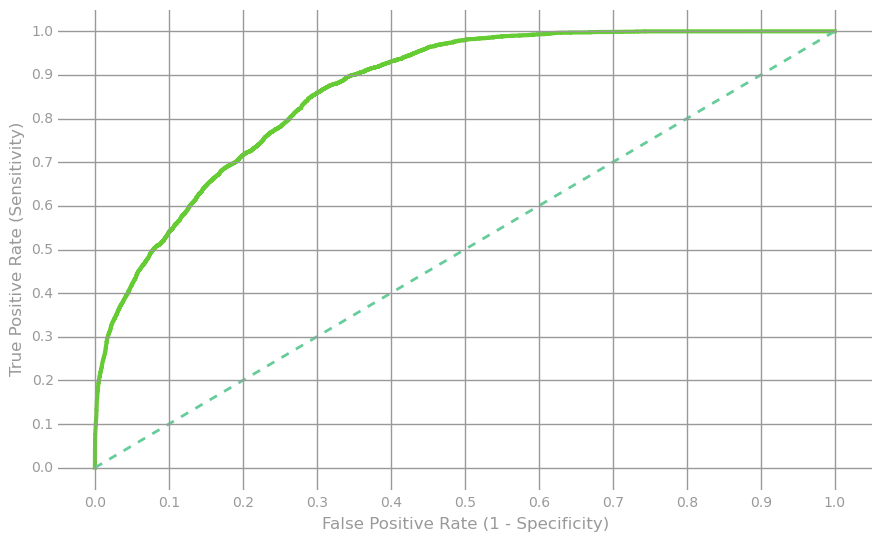

In [19]:
import matplotlib.pyplot as plt


def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

labelsAndScores = OHETrainData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#66CC33', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#66CC99', linewidth=2.)  # Baseline model 
pass

In [20]:
from sklearn import metrics
metrics.auc(falsePositiveRate, truePositiveRate)

0.86614268744286815

In [21]:
logLossValBase = OHEValData.map(lambda lp: LogLoss(instFractionTrain, lp.label)).mean()
logLossValLR0 = evaluate(model0, OHEValData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

# Examine highest five predictions of validation set
probsAndLabels = OHEValData.map(lambda lp: (getPred(lp.features, model0.weights, model0.intercept), lp.label))
print probsAndLabels.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

OHE Features Validation Logloss:
	Baseline = 0.072
	LogReg = 0.060
[(0.18302403883155013, 1.0), (0.17508543268466595, 1.0), (0.1643240893348191, 1.0), (0.15618909345023263, 1.0), (0.14801977400363878, 1.0)]


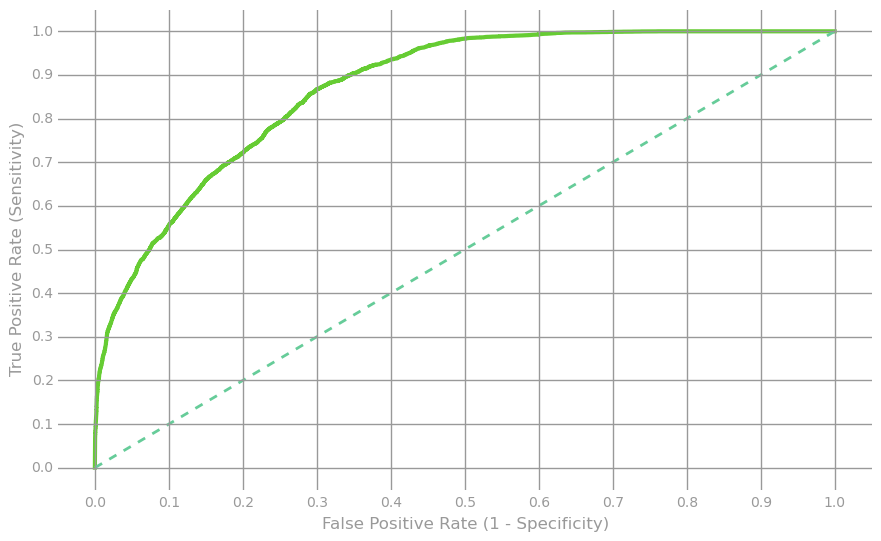

In [22]:
labelsAndScores = OHEValData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#66CC33', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#66CC99', linewidth=2.)  # Baseline model 
pass

In [23]:
from sklearn import metrics
metrics.auc(falsePositiveRate, truePositiveRate)

0.87057936363834376

The results of the first model look promising. However, this includes a feature that does not appropriately train the model. The second feature is a value that only occurs if an install occurred. Therefore, it is not appropriate to model. If a click occurred and that time is recorded, it cannot be assumed that the user will not install just because that dataset does not have a recorded install datetime. Therefore in the next model, I will take out this feature. I will also try to include more data and use feature hashing instead of one hot encoding.

###__Model 2__

In [4]:
# Load appropriate packages
from pyspark.mllib.regression import LabeledPoint 
from pyspark.mllib.linalg import SparseVector
import numpy as np

In [5]:
weights = [.9, .05, .05] # Fraction of data for training
seed = 32

# Use randomSplit with weights and seed, partition
mostData2, rawTrainData2, rawValData2 = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData2.cache()
rawValData2.cache()

PythonRDD[4] at RDD at PythonRDD.scala:43

In [7]:
def parseLine(line):
    p = line.split('\t')
    return [str(0) + p[0].encode('ascii', 'ignore')] + [str(i-1) + p[i].encode('ascii', 'ignore') for i in range(2,24)] # Skipping feature 2 and setup for hashing

parsedTrainFeat2 = rawTrainData2.map(parseLine)
print parsedTrainFeat2.take(1)

[['02015-07-30 00:00:00', '1\\N', '249ae49a23f67c759bf4fc791ba842aa2', '32', '4d41d8cd98f00b204e9800998ecf8427e', '55c3bed7777c3ff23112626965b946ffa', '6RU', '755.75', '837.616600036621', '9\\N', '10\\N', '11\\N', '12\\N', '13iPhone', '1417', '158', '164', '1736', '188', '194', '20697766074', '21\\N', '22Rainly -WW']]


In [8]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    mapping = {}
    for category in rawFeats:
        mapping[category] = int(int(hashlib.md5(category).hexdigest(), 16) % numBuckets)    
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

In [10]:
def parseHashPoint(point, numBuckets):
    p = point.split('\t')
    return LabeledPoint(p[24], SparseVector(numBuckets, hashFunction(numBuckets,parseLine(point),False)))

numBucketsIR = 2 ** 15
hashTrainData = rawTrainData2.map(lambda point: parseHashPoint(point,numBucketsIR))
hashTrainData.cache()



print hashTrainData.take(1)

[LabeledPoint(0.0, (32768,[1658,2817,8236,9140,9429,12205,13422,14047,15523,15761,16183,16910,17926,18229,18720,19885,20480,23882,24144,24383,29123,30490,30659],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [11]:
hashValidationData = rawValData2.map(lambda point: parseHashPoint(point,numBucketsIR))
hashValidationData.cache()
print hashValidationData.take(1)

[LabeledPoint(0.0, (32768,[3121,3696,4307,8236,9865,13422,14994,15761,16183,16274,18229,18812,18996,19173,20103,20928,24046,24144,26505,28405,28869,29023,31453],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [12]:
trainInstalls = hashTrainData.filter(lambda lp: lp.label == 1).count()
trainTot = hashTrainData.count()
ValInstalls = hashValidationData.filter(lambda lp: lp.label == 1).count()
ValTot = hashValidationData.count()

print 'Percentage of installs Train = {0:.3f}'.format(trainInstalls/float(trainTot))
print 'Percentage of installs Validation = {0:.3f}'.format(ValInstalls/float(ValTot))

Percentage of installs Train = 0.013
Percentage of installs Validation = 0.013


In [13]:
from pyspark.mllib.classification import LogisticRegressionWithSGD 

# Fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model1 = LogisticRegressionWithSGD.train(hashTrainData, numIters, regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model1.weights)
print sortedWeights[:5], model1.intercept # Examine five weights and intercept of model

[-0.83123816162168762, -0.58874446346111742, -0.55521284422932005, -0.52914616815289772, -0.51023947983542506] 0.168773624264


In [14]:
from math import log

def LogLoss(p, y):
    epsilon = 10e-12 # To keep range between 0 and 1
    if p == 0:
      p = epsilon
    elif p == 1:
      p = p - epsilon
    if y == 1:
      ll = -log(p)
    elif y == 0: 
      ll = -log(1-p)
    return ll

In [15]:
instFractionTrainH = hashTrainData.map(lambda lp: lp.label).mean()# Fraction of training with class one
print instFractionTrainH

logLossTrBaseHash = hashTrainData.map(lambda lp: LogLoss(instFractionTrainH, lp.label)).mean()
print 'Baseline Train Logloss Hash = {0:.3f}'.format(logLossTrBaseHash)

0.0134183730296
Baseline Train Logloss Hash = 0.071


In [16]:
from math import exp 

def getPred(x, w, intercept):
    rawPrediction = x.dot(w) + intercept 
    return float((1+exp(-rawPrediction))**(-1))

trainingPredictionsH = hashTrainData.map(lambda lp: getPred(lp.features, model1.weights, model1.intercept))
print trainingPredictionsH.take(20)

[0.02199150371497694, 0.021957005501858372, 0.024695021451459357, 0.013310444737043885, 0.02472622373191032, 0.058479172489318346, 0.024682886883867532, 0.018393472294866632, 0.02441435973912308, 0.06251894455391742, 0.025261832201578977, 0.04563641921952233, 0.017572667759530848, 0.04198301286271768, 0.026525558237725077, 0.02631618052463759, 0.03945511997007898, 0.06241206762367815, 0.02092117325046867, 0.019354825457391263]


In [17]:
def evaluate(model, data):
    p = data.map(lambda lp: getPred(lp.features, model.weights, model.intercept)).collect()
    y = data.map(lambda lp: lp.label).collect()
    logLoss = []
    for i in range(len(p)):
      logLoss.append(LogLoss(p[i], y[i]))
    return np.mean(logLoss) # Mean of log loss between each prediction and label
  
logLossTrLR1 = evaluate(model1, hashTrainData)
print ('Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBaseHash, logLossTrLR1))

# Examine highest five predictions of training set
probsAndLabelsTrainH = hashTrainData.map(lambda lp: (getPred(lp.features, model1.weights, model1.intercept), lp.label))
print probsAndLabelsTrainH.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

Train Logloss:
	Baseline = 0.071
	LogReg = 0.072
[(0.12957427255143703, 1.0), (0.11772786272550813, 1.0), (0.11310581021738543, 1.0), (0.10626033959887458, 1.0), (0.09739701069361652, 1.0)]


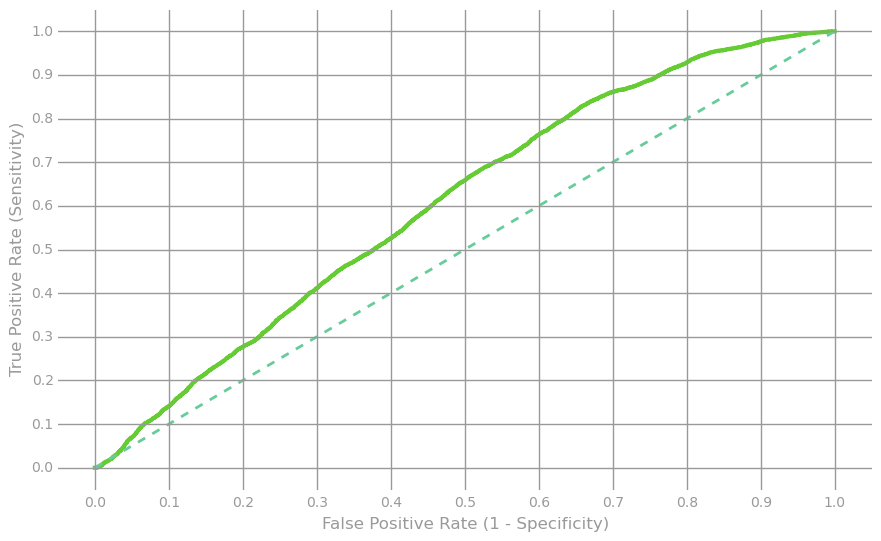

In [18]:
import matplotlib.pyplot as plt


def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

labelsAndScores = hashTrainData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model1.weights, model1.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#66CC33', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#66CC99', linewidth=2.)  # Baseline model 
pass

In [19]:
from sklearn import metrics
metrics.auc(falsePositiveRate, truePositiveRate)

0.60516171420269194

In [20]:
logLossValBaseHash = hashValidationData.map(lambda lp: LogLoss(instFractionTrainH, lp.label)).mean()
logLossValLR1 = evaluate(model1, hashValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBaseHash, logLossValLR1))

# Examine highest five predictions of validation set
probsAndLabelsH = hashValidationData.map(lambda lp: (getPred(lp.features, model1.weights, model1.intercept), lp.label))
print probsAndLabelsH.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

OHE Features Validation Logloss:
	Baseline = 0.071
	LogReg = 0.072
[(0.11044390090804246, 1.0), (0.10672418991582529, 1.0), (0.10275717468027455, 1.0), (0.09812331196695324, 1.0), (0.09768423935956132, 1.0)]


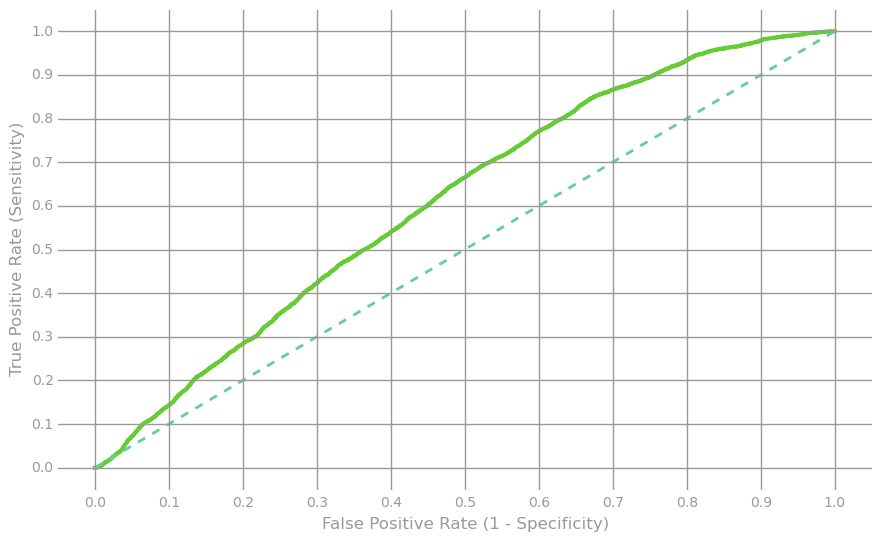

In [21]:
labelsAndScores = hashValidationData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model1.weights, model1.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#66CC33', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#66CC99', linewidth=2.)  # Baseline model 
pass

In [22]:
from sklearn import metrics
metrics.auc(falsePositiveRate, truePositiveRate)

0.61128620166902592

Clearly, the time stamp for the install was over-fitting the model. The AUC went form .87 to .61, which is not good at all. However, it is more appropriate. Again, it cannot be assumed that an install will not occur just because there is no time stamp yet presented.

For the next model I will try to add in additional features to see if this will help provide a better fit for the model.

###__Model 3__

In [4]:
# Load appropriate packages
from pyspark.mllib.regression import LabeledPoint 
from pyspark.mllib.linalg import SparseVector
import numpy as np

In [5]:
weights = [.95, .025, .025] # Fraction of data for training
seed = 25

# Use randomSplit with weights and seed, partition
mostData3, rawTrainData3, rawValData3 = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData3.cache()
rawValData3.cache()

PythonRDD[4] at RDD at PythonRDD.scala:43

In [6]:
rawTrainData3 = rawTrainData3.map(addfeats)
print rawTrainData3.take(1)

[u'2015-07-30 00:00:03\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t55.75\t37.616600036621\t\\N\t\\N\t\\N\t\\N\tiPhone\t17\t8\t4\t36\t8\t4\t667728512\tcom.machinezone.gow\tGame of War - Fire Age\t0\t9+\tUSD\t4.5\t6014\tGames\tFree\t83085']


In [7]:
rawTrainData3 = rawTrainData3.filter(None)
print rawTrainData3.take(3)
rawTrainData3.cache()

[u'2015-07-30 00:00:03\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t55.75\t37.616600036621\t\\N\t\\N\t\\N\t\\N\tiPhone\t17\t8\t4\t36\t8\t4\t667728512\tcom.machinezone.gow\tGame of War - Fire Age\t0\t9+\tUSD\t4.5\t6014\tGames\tFree\t83085', u'2015-07-30 00:00:20\t\\N\t\\N\t8eefcfdf5990e441f0fb6f3fad709e21\t2\t8e77b3768b440a281c5101ca7941d5e0\td8628f0cadddbfc9dfc84f030f41847a\tUS\t40.100898742676\t-83.014099121094\t535\tOH\tColumbus\t43085\tiPhone\t17\t8\t3\t36\t8\t0\t302324249\t302324249\tSkout - Meet, Chat, Friend\t0\t17+\tUSD\t4.0\t6005\tSocial Networking\tFree\t174255', u'2015-07-30 00:00:34\t\\N\t\\N\tb337e84de8752b27eda3a12363109e80\t1\t9592593be776ba10fbe1f370da0a4b67\td62677e74306f64b124e6b5f4d7f6925\tUS\t0\t0\t\\N\tAE\tFpo\t\\N\tiPhone\t17\t7\t0\t36\t7\t0\t999096522\tcom.pepsi.pass\tPepsi Pass\t0\t17+\tUSD\t2.5\t6023\tFood & Drink\tFree\t179']


PythonRDD[7] at RDD at PythonRDD.scala:43

In [10]:
rawValData3 = rawValData3.map(addfeats)
print rawValData3.take(1)

[u'2015-07-30 00:00:03\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t55.75\t37.616600036621\t\\N\t\\N\t\\N\t\\N\tiPhone\t17\t8\t4\t36\t8\t4\t667728512\tcom.machinezone.gow\tGame of War - Fire Age\t0\t9+\tUSD\t4.5\t6014\tGames\tFree\t83085']


In [11]:
rawValData3 = rawValData3.filter(None)
print rawValData3.take(3)
rawValData3.cache()

[u'2015-07-30 00:00:03\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t55.75\t37.616600036621\t\\N\t\\N\t\\N\t\\N\tiPhone\t17\t8\t4\t36\t8\t4\t667728512\tcom.machinezone.gow\tGame of War - Fire Age\t0\t9+\tUSD\t4.5\t6014\tGames\tFree\t83085', u'2015-07-30 00:00:14\t\\N\t\\N\t49ae49a23f67c759bf4fc791ba842aa2\t2\td41d8cd98f00b204e9800998ecf8427e\t5c3bed7777c3ff23112626965b946ffa\tRU\t55.75\t37.616600036621\t\\N\t\\N\t\\N\t\\N\tiPhone\t17\t8\t4\t36\t8\t4\t449655162\t\\N\tGetTaxi - iOS\t0\t4+\tUSD\t4.0\t6003\tTravel\tFree\t916', u'2015-07-30 00:00:20\t\\N\t\\N\t8eefcfdf5990e441f0fb6f3fad709e21\t2\t8e77b3768b440a281c5101ca7941d5e0\td8628f0cadddbfc9dfc84f030f41847a\tUS\t40.100898742676\t-83.014099121094\t535\tOH\tColumbus\t43085\tiPhone\t17\t8\t3\t36\t8\t0\t302324249\t302324249\tSkout - Meet, Chat, Friend\t0\t17+\tUSD\t4.0\t6005\tSocial Networking\tFree\t174255']


PythonRDD[13] at RDD at PythonRDD.scala:43

In [8]:
def parseLine(line):
    p = line.split('\t')
    return ([str(i-2) + p[i].encode('ascii', 'ignore') for i in range(2,24)] + 
            [str(i-3) + p[i].encode('ascii', 'ignore') for i in range(25,32)])

#parsedTrainFeat3 = rawTrainData3.map(parseLine)
#print parsedTrainFeat3.take(1)

In [9]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    mapping = {}
    for category in rawFeats:
        mapping[category] = int(int(hashlib.md5(category).hexdigest(), 16) % numBuckets)    
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

In [ ]:
def parseHashPoint(point, numBuckets):
    p = point.split('\t')
    return LabeledPoint(p[24], SparseVector(numBuckets, hashFunction(numBuckets,parseLine(point),False)))

numBucketsIR = 2 ** 15
hashTrainData = rawTrainData3.map(lambda point: parseHashPoint(point,numBucketsIR))
hashTrainData.cache()



print hashTrainData.take(1)

Unfortunately, the runtime for this particular set of code is getting excessive and I will not be able to complete the third model. This is probably due to the lazy transformations in spark. It did not fully perform the addfeats function and is trying to perform this action in addition to the other fucntions I have defined above.

In [ ]:
hashValidationData = rawValData3.map(lambda point: parseHashPoint(point,numBucketsIR))
hashValidationData.cache()
print hashValidationData.take(1)

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithSGD 

# Fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

model2 = LogisticRegressionWithSGD.train(hashTrainData, numIters, regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model2.weights)
print sortedWeights[:5], model2.intercept # Examine five weights and intercept of model

In [ ]:
from math import log

def LogLoss(p, y):
    epsilon = 10e-12 # To keep range between 0 and 1
    if p == 0:
      p = epsilon
    elif p == 1:
      p = p - epsilon
    if y == 1:
      ll = -log(p)
    elif y == 0: 
      ll = -log(1-p)
    return ll

In [ ]:
instFractionTrainH = hashTrainData.map(lambda lp: lp.label).mean()# Fraction of training with class one
print instFractionTrainH

logLossTrBaseHash = hashTrainData.map(lambda lp: LogLoss(instFractionTrainH, lp.label)).mean()
print 'Baseline Train Logloss Hash = {0:.3f}'.format(logLossTrBaseHash)

In [ ]:
from math import exp 

def getPred(x, w, intercept):
    rawPrediction = x.dot(w) + intercept 
    return float((1+exp(-rawPrediction))**(-1))

trainingPredictionsH = hashTrainData.map(lambda lp: getPred(lp.features, model2.weights, model2.intercept))
print trainingPredictionsH.take(20)

In [ ]:
def evaluate(model, data):
    p = data.map(lambda lp: getPred(lp.features, model.weights, model.intercept)).collect()
    y = data.map(lambda lp: lp.label).collect()
    logLoss = []
    for i in range(len(p)):
      logLoss.append(LogLoss(p[i], y[i]))
    return np.mean(logLoss) # Mean of log loss between each prediction and label
  
logLossTrLR2 = evaluate(model2, hashTrainData)
print ('Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBaseHash, logLossTrLR2))

# Examine highest five predictions of training set
probsAndLabelsTrainH = hashTrainData.map(lambda lp: (getPred(lp.features, model2.weights, model2.intercept), lp.label))
print probsAndLabelsTrainH.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

In [ ]:
import matplotlib.pyplot as plt


def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

labelsAndScores = hashTrainData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model2.weights, model2.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#66CC33', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#66CC99', linewidth=2.)  # Baseline model 
pass

In [ ]:
from sklearn import metrics
metrics.auc(falsePositiveRate, truePositiveRate)

In [ ]:
logLossValBaseHash = hashValidationData.map(lambda lp: LogLoss(instFractionTrainH, lp.label)).mean()
logLossValLR2 = evaluate(model2, hashValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBaseHash, logLossValLR2))

# Examine highest five predictions of validation set
probsAndLabelsH = hashValidationData.map(lambda lp: (getPred(lp.features, model2.weights, model2.intercept), lp.label))
print probsAndLabelsH.filter(lambda x: x[1] ==1).takeOrdered(5, key = lambda x: -x[0])

In [ ]:
labelsAndScores = hashValidationData.map(lambda lp:
                                            (lp.label, getPred(lp.features, model2.weights, model2.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#66CC33', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#66CC99', linewidth=2.)  # Baseline model 
pass

In [ ]:
from sklearn import metrics
metrics.auc(falsePositiveRate, truePositiveRate)

##__Conclusions__

The results are intriguing. I would have liked to have been able to use additional features and more data. I believe that if I had a better setup and more processing power, things would have been more efficient. If I had more time, I would have figured out a better method for attaching the additional features to the dataset and would have tried other types of models. I appreciate the opportunity to work with this data and am inspired by your company's work. 

###__Key Take Aways & Lessons learned__

1. It is very important how you structure your transformations and actions. When working with large datasets, the setup is essential to how fast your code will run.
2. You must pay attention to what attributes you are using and why they are important. It can be easy to assume that your model is great without realizing how you may be overfitting or using attributes that are unrealistic.